# Primer Proyecto de Simulación | Predicciones de Halterofilia para París 2024

Integrantes:
- Ariel González Gómez C312 <br>
- Alex Samuel Bas Beovides C312 <br>
---

El objetivo del proyecto es confeccionar un modelo computacional para simular la competición de Levantamiento de Pesas (Halterofilia) de los Juegos Olímpicos de París 2024, haciendo análisis y pruebas de hipótesis para determinar los parámetros que conformen un modelo más consistente con la realidad, y de esta manera intentar predecir, de manera precisa, el ranking que resultará en dicha competencia futura.

## Descripción

La competición de Levantamiento de Pesas de los Juegos Olímpicos de París 2024, consiste de 10 categorías de peso independientes, 5 de mujeres (49 Kg, 59 Kg, 71 Kg, 81 Kg, y más de 81 Kg) y 5 de hombres (61 Kg, 73 Kg, 89 Kg, 102 Kg, y más de 102 Kg). En cada una están presentes entre 10 y 12 atletas de distintos países. Los atletas clasificados ya se conocen, y sus datos fueron obtenidos haciendo Scrapping en el sitio web International Weightlifting Results Project (https://iwrp.net/), el cual contiene los resultados de muchas competencias recientes de levantamiento de pesas, en tablas para cada torneo donde se conocen los pesos de los intentos exitosos o fallidos de los atletas, y el ranking resultante. Cada categoría es un torneo independiente, y todas mantienen el mismo formato:

Hay dos formatos de levantamiento: envión (Snatch) y arrancada (Clean and Jerk). En ambos los atletas tendrán 3 intentos para cargar pesos distintos, en orden no decreciente, y el resultado del atleta en la competencia se toma como la suma del mayor peso cargado con éxito en ambos formatos (o valor nulo en caso de tener 3 intentos fallidos en alguno de los formatos). Ambos formatos son independientes y tienen la misma descripción: 

La competencia de cualquiera de los dos formatos de una categoría determinada inicia con la selección, por parte de cada participante, de un peso inicial a intentar cargar como primer intento, y este tiene que ser no menor que un peso mínimo específico. Después de todas las selecciones, los pesos pedidos se ordenan en orden no decreciente, para determinar el orden en que los atletas efectúan su intento. En cada intento el atleta es exitoso o no, mejorando o no su mayor peso cargado en el formato. Luego del intento, si aún no es el tercero de ellos, el atleta decide el peso del siguiente intento, que debe ser no menor que el último, y este se introduce en la cola de orden, de forma tal que los intentos siempre son en orden no decreciente de peso. Luego de que son efectuados los 3 intentos de cada atleta en ambos formatos, se suman los mejores resultados. El ranking se determina ordenando primero por mayor suma, y en caso de empate gana el atleta que obtuvo primero su mejor resultado (por orden de intentos). Con esto se confecciona el ranking de una categoría de peso.

## Configuración del entorno

In [1]:
# Importa las bibliotecas necesarias
import ast
import json
import tabulate
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from heapq import heappush, heappop

### Funciones útiles

In [3]:
def convert_to_list(s):
  """Convierte una cadena 's' en una lista de enteros.

  Args:
    s: La cadena que se va a convertir. Se espera que tenga el formato '[valor_1, valor_2, ..., valor_n]'.

  Returns:
    Una lista de enteros convertida a partir de la cadena 's'.
  """

  # Evalúa la cadena 's' como una lista literal usando 'literal_eval'
  list_ = ast.literal_eval(s)

  # Recorre la lista y convierte las cadenas '0' a 0
  for i in range(len(list_)):
    # Recorre cada elemento de la lista. Si es una cadena '0', se convierte a 0.
    if isinstance(list_[i], str) and list_[i] == '0':
      list_[i] = 0

  # Convierte la lista a una lista de enteros
  list_ = [int(x) for x in list_]

  return list_

## Análisis estadísticos

### Primer intento

¿Cómo simular la selección del primer intento para un atleta determinado en cierto formato? Nuestra hipótesis es que en el primer intento el atleta por lo general va a lo seguro, e intentará cargar un peso cercano y algo inferior a sus resultados recientes en entrenamientos. Sin embargo, no tenemos acceso a los datos de entrenamiento de los atletas, sino a sus resultados en competencias pasadas, que deben reflejar en menor o mayor medida el rendimiento esperado. Consideramos entonces que una métrica sensata debe ser un promedio de los resultados de dichas competencias. Sin embargo, este promedio debe ser ponderado, ya que se le debe dar más significancia a los resultados más recientes por sobre los demás, por lo que optamos por repetir el resultado un número de veces dependiente del año en que se obtuvo el resultado, para luego tomar el promedio de la unión. Específicamente, se tomaron 10 repeticiones para resultados de 2024, 5 para los de 2023, 3 para los de 2022 y 1 para los de 2021 (parámetros a aplicarles Fine-Tuning).

Este promedio ponderado se utiliza también para determinar la probabilidad de éxito del intento de un atleta de levantar un peso en un formato determinado. A continuación se computarán dichos rendimientos promedio conjuntamente con otros datos relevantes al resto de análisis:

In [4]:
# Crea listas para almacenar las categorías de peso y los dataframes de los atletas
weight_classes = []
weight_classes_dfs = []

# Crea listas para almacenar las diferencias entre el promedio ponderado de rendimiento y el primer intento del atleta en su último torneo
first_attempt_deviations_snatch = []
first_attempt_deviations_clean_and_jerk = []

# Crea listas de pares de (diferencia, exitoso) para almacenar las diferencias entre cada intento con el promedio ponderado de rendimiento del atleta en su último torneo, y si fue exitoso o no
attempts_snatch = []
attempts_clean_and_jerk = []

# Crea listas de diferencias entre intentos consecutivos para cada formato de levantamiento y resultado del intento previo
success_first_to_second_snatch = []
fail_first_to_second_snatch = []
success_second_to_third_snatch = []
fail_second_to_third_snatch = []
success_first_to_second_clean_and_jerk = []
fail_first_to_second_clean_and_jerk = []
success_second_to_third_clean_and_jerk = []
fail_second_to_third_clean_and_jerk = []

In [6]:
def load_data(data_file):
    # Carga variables globales
    global weight_classes
    global weight_classes_dfs

    global first_attempt_deviations_snatch
    global first_attempt_deviations_clean_and_jerk

    global attempts_snatch
    global attempts_clean_and_jerk

    global success_first_to_second_snatch
    global fail_first_to_second_snatch
    global success_second_to_third_snatch
    global fail_second_to_third_snatch
    global success_first_to_second_clean_and_jerk
    global fail_first_to_second_clean_and_jerk
    global success_second_to_third_clean_and_jerk
    global fail_second_to_third_clean_and_jerk

    # Carga el archivo JSON en un diccionario de Python
    with open(data_file) as f:
        data = json.load(f)

    # Limpia las listas globales
    weight_classes = []
    weight_classes_dfs = []
    first_attempt_deviations_snatch = []
    first_attempt_deviations_clean_and_jerk = []
    attempts_snatch = []
    attempts_clean_and_jerk = []
    success_first_to_second_snatch = []
    fail_first_to_second_snatch = []
    success_second_to_third_snatch = []
    fail_second_to_third_snatch = []
    success_first_to_second_clean_and_jerk = []
    fail_first_to_second_clean_and_jerk = []
    success_second_to_third_clean_and_jerk = []
    fail_second_to_third_clean_and_jerk = []

    # Itera sobre las categorías de peso
    for weight_class, athletes in data.items():
        weight_classes.append(weight_class)

        # Crea un dataframe vacío para almacenar los datos de los atletas
        athletes_df = pd.DataFrame({
            "name": [],
            "gender": [],
            "average_snatch": [],
            "average_clean_and_jerk": [],
        })

        # Itera sobre los atletas
        for athlete, athlete_data in athletes.items():
            gender = athlete_data['sex']

            snatch_results = []
            clean_and_jerk_results = []

            # Itera sobre los torneos
            for tournament in athlete_data['data']:
                weights = convert_to_list(tournament['Weights'])

                # Obtiene el mejor resultado de snatch y de clean & jerk
                best_snatch = max(weights[0:3])
                best_clean_and_jerk = max(weights[3:6])

                bonus_map = {'2024':10,'2023':5,'2022':3,'2021':1}
                bonus = bonus_map[tournament['Date'].split('-')[0]]

                # Agrega los resultados a las listas
                if best_snatch > 0:
                    snatch_results.extend([best_snatch] * bonus)
                
                if best_clean_and_jerk > 0:
                    clean_and_jerk_results.extend([best_clean_and_jerk] * bonus)

                # Añade diferencias entre intentos consecutivos:
                if weights[0] != 0 and weights[1] != 0:
                    if weights[0] < 0:
                        fail_first_to_second_snatch.append(abs(weights[1]) - abs(weights[0]))
                    else:
                        success_first_to_second_snatch.append(abs(weights[1]) - abs(weights[0]))

                if weights[1] != 0 and weights[2] != 0:
                    if weights[1] < 0:
                        fail_second_to_third_snatch.append(abs(weights[2]) - abs(weights[1]))
                    else:
                        success_second_to_third_snatch.append(abs(weights[2]) - abs(weights[1]))

                if weights[3] != 0 and weights[4] != 0:
                    if weights[3] < 0:
                        fail_first_to_second_clean_and_jerk.append(abs(weights[4]) - abs(weights[3]))
                    else:
                        success_first_to_second_clean_and_jerk.append(abs(weights[4]) - abs(weights[3]))

                if weights[4] != 0 and weights[5] != 0:
                    if weights[4] < 0:
                        fail_second_to_third_clean_and_jerk.append(abs(weights[5]) - abs(weights[4]))
                    else:
                        success_second_to_third_clean_and_jerk.append(abs(weights[5]) - abs(weights[4]))
                

            # Calcula el promedio de los resultados
            if len(snatch_results) == 0 or len(clean_and_jerk_results) == 0:
                print(athlete)

            average_snatch = sum(snatch_results)/(len(snatch_results))
            average_clean_and_jerk = sum(clean_and_jerk_results)/(len(clean_and_jerk_results))

            # Crea un dataframe con los datos del atleta
            df = pd.DataFrame({
                "name": [athlete],
                "gender": [gender],
                "average_snatch": [average_snatch],
                "average_clean_and_jerk": [average_clean_and_jerk],
            })

            # Agrega el dataframe del atleta al dataframe de la categoría de peso
            athletes_df = pd.concat([athletes_df, df], ignore_index=True)

            # Obtiene los intentos del último torneo
            last_tournament_weights = convert_to_list(athlete_data['data'][-1]['Weights'])

            # Agrega los intentos a lista de pares (diferencia, exitoso) respecto al rendimiento promedio
            for weight in last_tournament_weights[0:3]:
                if weight < 0:
                    if -weight - average_snatch > -60:
                        attempts_snatch.append((-weight - average_snatch, 0))
                elif weight > 0:
                    if weight - average_snatch > -60:
                        attempts_snatch.append((weight - average_snatch, 1))

            for weight in last_tournament_weights[3:6]:
                if weight < 0:
                    if -weight - average_clean_and_jerk > -60:
                        attempts_clean_and_jerk.append((-weight - average_clean_and_jerk, 0))
                elif weight > 0:
                    if weight - average_clean_and_jerk > -60:
                        attempts_clean_and_jerk.append((weight - average_clean_and_jerk, 1))

            # Agrega los datos de desviación del primer intento respecto al rendimiento promedio
            first_attempt_snatch = last_tournament_weights[0]
            first_attempt_clean_and_jerk = last_tournament_weights[3]

            if first_attempt_snatch < 0:
                first_attempt_snatch = -first_attempt_snatch
            if first_attempt_clean_and_jerk < 0:
                first_attempt_clean_and_jerk = -first_attempt_clean_and_jerk

            if first_attempt_snatch > 0 and first_attempt_snatch - average_snatch > -60:
                first_attempt_deviations_snatch.append(first_attempt_snatch - average_snatch)
            if first_attempt_clean_and_jerk > 0:
                first_attempt_deviations_clean_and_jerk.append(first_attempt_clean_and_jerk - average_clean_and_jerk)

        # Agrega el dataframe de la categoría de peso a la lista de dataframes
        weight_classes_dfs.append(athletes_df)

load_data('classified.json')

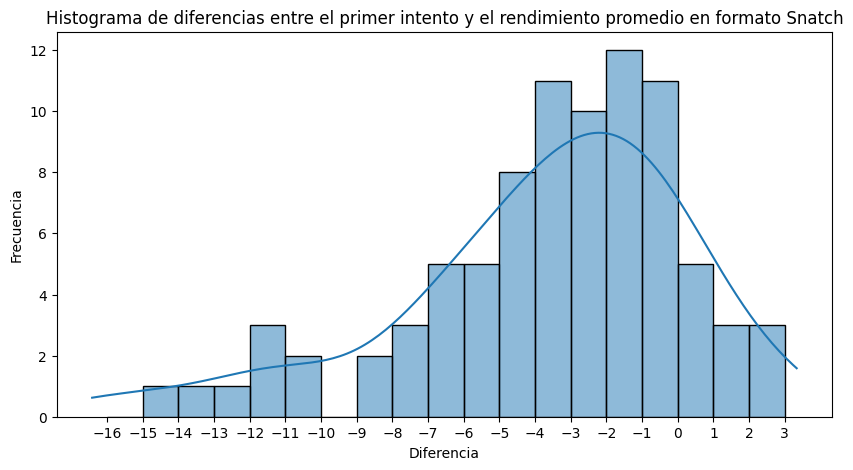

Media (Snatch): -3.827361190123528
Desviación estándar (Snatch): 4.12002044513876


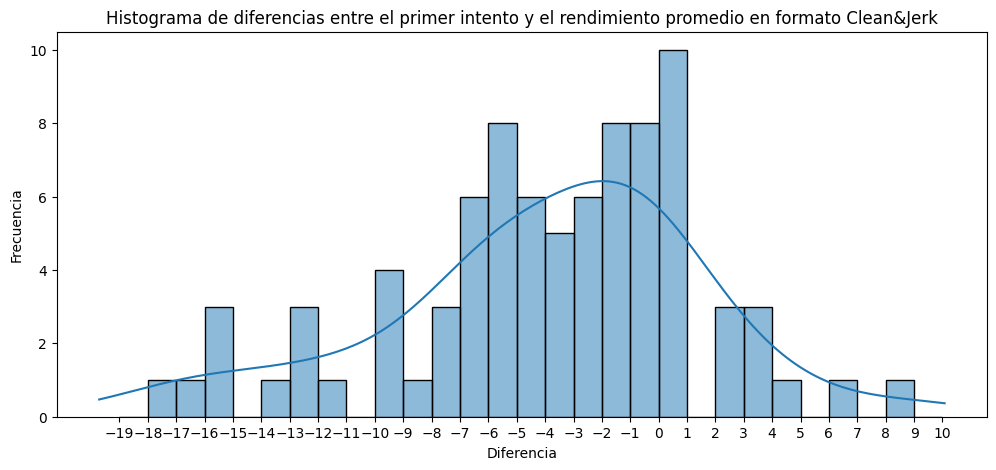

Media (Clean&Jerk): -3.9957011835348655
Desviación estándar (Clean&Jerk): 5.675358278957747


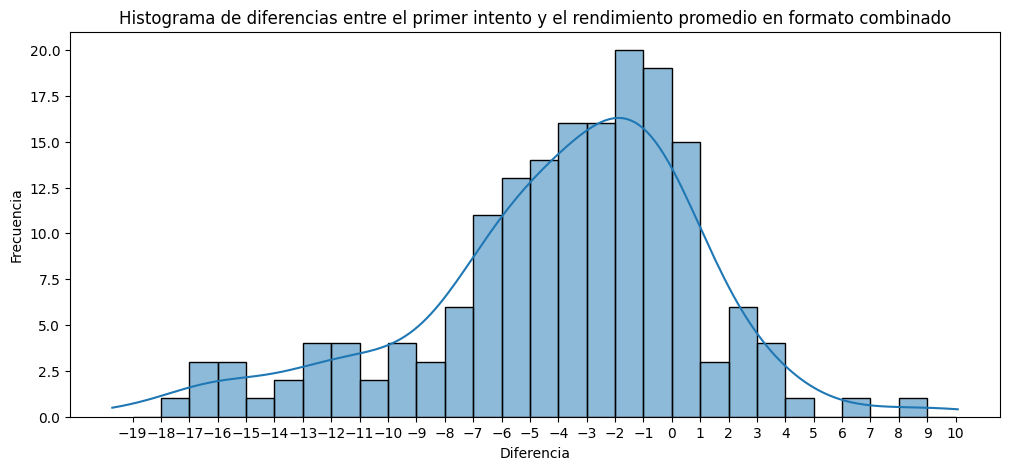

Media (combinado): -3.910088272599957
Desviación estándar (combinado): 4.946577177012289


In [75]:
def plot_first_attempt_deviations_histogram(deviations, format, size):
    """ Crea un histograma de las desviaciones del primer intento respecto al rendimiento promedio.

    Args:
        deviations (list): Una lista de las desviaciones del primer intento respecto al rendimiento promedio.

    Returns:
        None
    """

    # Crea el histograma
    plt.figure(figsize=size)
    sns.histplot(deviations, kde=True, bins=range((int)(min(deviations)), (int)(max(deviations)) + 1), stat="count")
    plt.xlabel("Diferencia")
    plt.ylabel("Frecuencia")
    plt.title("Histograma de diferencias entre el primer intento y el rendimiento promedio en formato " + format)
    plt.xticks(range((int)(min(deviations)), (int)(max(deviations)) + 1))  # Asegura que los ticks estén en números enteros
    plt.show()

# Grafica el histograma del formato Snatch
plot_first_attempt_deviations_histogram(first_attempt_deviations_snatch, "Snatch", (10, 5))
print("Media (Snatch):", np.mean(first_attempt_deviations_snatch))
print("Desviación estándar (Snatch):", np.std(first_attempt_deviations_snatch))

# Grafica el histograma del formato Clean&Jerk
plot_first_attempt_deviations_histogram(first_attempt_deviations_clean_and_jerk, "Clean&Jerk", (12, 5))
print("Media (Clean&Jerk):", np.mean(first_attempt_deviations_clean_and_jerk))
print("Desviación estándar (Clean&Jerk):", np.std(first_attempt_deviations_clean_and_jerk))

# Grafica el histograma de todos los resultados (combinados ambos formatos)
plot_first_attempt_deviations_histogram(first_attempt_deviations_snatch + first_attempt_deviations_clean_and_jerk, "combinado", (12, 5))
print("Media (combinado):", np.mean(first_attempt_deviations_snatch + first_attempt_deviations_clean_and_jerk))
print("Desviación estándar (combinado):", np.std(first_attempt_deviations_snatch + first_attempt_deviations_clean_and_jerk))

Podemos comprobar que la diferencia entre el primer intento y el rendimiento promedio en ambos formatos tiene distribución aproximadamente normal con media alrededor de -4 Kg y desviación estándar de aproximadamente 4.1 para Snatch y 5.6 para Clean&Jerk, combinado 4 de media y 5 de desviación, aproximadamente.

### Probabilidad de éxito del intento

¿Cómo simular el éxito o fallo del intento de un atleta de levantar un peso en un formato determinado? Arribamos a la hipótesis de que un atleta por lo general debe poder levantar con relativa seguridad un peso cercano a su rendimiento promedio (el mismo que el discutido anteriormente), y la probabilidad de éxito disminuye de forma rápida (exponencialmente) a medida que aumenta la cantidad de kilogramos por encima de dicho promedio, y de forma análoga aumenta rápidamente a medida que disminuye el peso. Una función que aproxima este comportamiento con cierta fidelidad es la sigmoidal o Función Sigmoide (ver gráfica):

In [25]:
def success_probability(weight_to_lift, avg):
  """Calcula la probabilidad de éxito para un peso dado a levantar.

  La probabilidad es de alrededor de 0.7 si weight_to_lift está alrededor del avg, y crece
  rápidamente más cerca de 1 a medida que se acerca a avg - 16, y disminuye rápidamente
  más cerca de 0 a medida que se acerca a avg + 20.

  Args:
    weight_to_lift: El peso a levantar en kilogramos.
    avg: El peso promedio levantado en kilogramos.

  Returns:
    La probabilidad de éxito.
  """

  # Calcula la diferencia entre el peso a levantar y el peso promedio.
  diff = avg + 4 - weight_to_lift

  # Calcula la probabilidad de éxito.
  # La probabilidad va de 0 a 1, donde 0 es completamente improbable y 1 completamente probable
  prob = 1 / (1 + np.exp(-diff / 4))

  # Devuelve la probabilidad.
  return prob

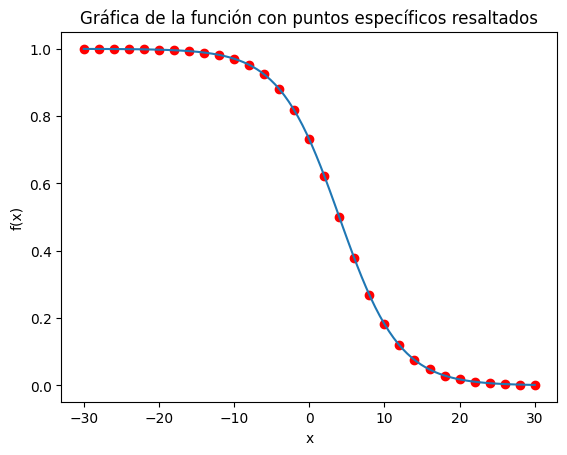

In [76]:
def plot_success_probability():
    """Grafica la función de probabilidad de éxito (success_probability).
    
    Args:
        None
        
    Returns:
        None
    """

    # Crea los datos para la gráfica
    x = np.linspace(-30, 30, 100)
    y = success_probability(100+x, 100)

    # Crea una lista de los valores específicos de x a graficar
    x_especific = list(range(-30, 31, 2))

    # Crea una lista de los valores correspondientes de y
    y_especific = [success_probability(100+x, 100) for x in x_especific]

    # Crea la gráfica
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.scatter(x_especific, y_especific, color='red')

    # Agrega etiquetas y título a los ejes
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title('Gráfica de la función con puntos específicos resaltados')

    # Muestra la gráfica
    plt.show()

plot_success_probability()

# for i in range(-30, 30):
#    print(i, success_probability(100+i, 100))

Graficaremos los datos reales para comprobar esta hipótesis:

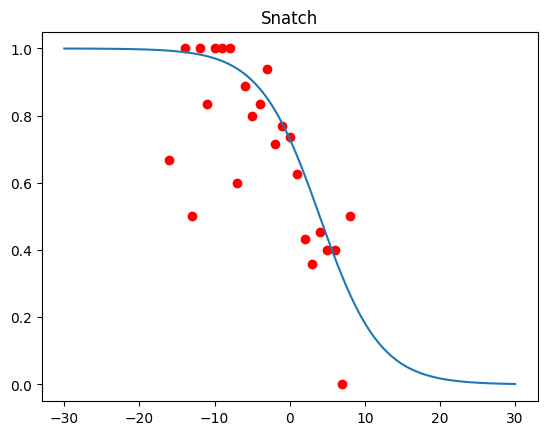

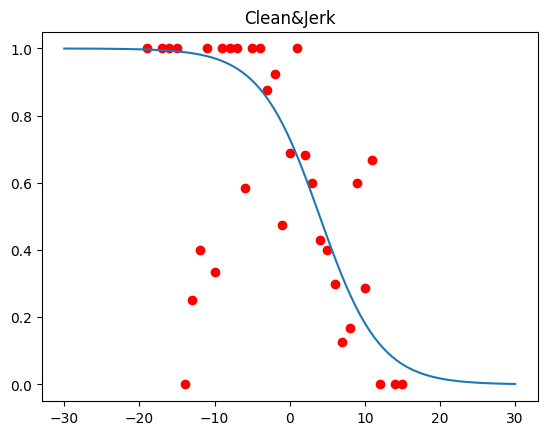

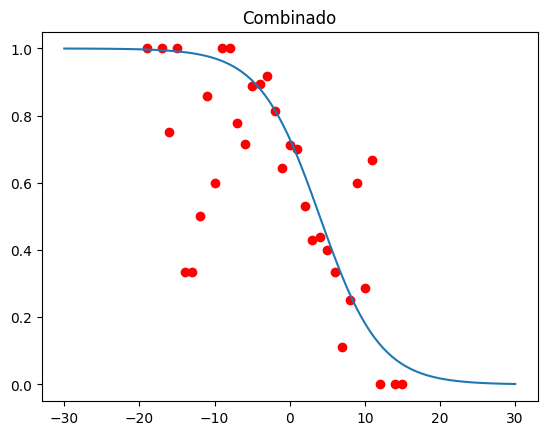

In [77]:
def plot_attempt_success_rate(attempts, format):
    """Grafica las diferencias de los intentos con respecto al rendimiento promedio y la tasa de éxito, para un formato dado. Superpone la gráfica de la función sigmoide para comparación.

    Args:
        attempts (list): Lista de tuplas (diferencia, éxito) para cada intento.
        format (str): Formato de los intentos.
    
    Returns:
        None
    """

    # Inicializar diccionarios para almacenar los conteos totales y los conteos de éxito para cada diferencia.
    total_counts = {}
    success_counts = {}
    difs = []

    # Iterar sobre los intentos y actualizar los diccionarios.
    for diff, success in attempts:
        dif = int(diff)
        try:
            total_counts[dif]
        except:
            # Si la diferencia no está en el diccionario, inicializar los conteos.
            total_counts[dif] = 0
            success_counts[dif] = 0
            difs.append(dif)

        # Incrementar el conteo total para la diferencia.
        total_counts[dif] += 1
        # Si el intento fue exitoso, incrementar el conteo de éxito para la diferencia.
        if success == 1:
            success_counts[dif] += 1

    # Inicializar listas para almacenar los valores x (diferencias) y los valores y (tasas de éxito).
    x_vals = []
    y_vals = []

    # Iterar sobre las diferencias y calcular las tasas de éxito.
    for dif in difs:
        x_vals.append(dif)
        y_vals.append(success_counts[dif] / total_counts[dif])

    # Graficar los puntos.
    plt.title(format)
    plt.plot(x_vals, y_vals, 'ro')

    # Crea los datos para la sigmoide
    x_vals = np.linspace(-30, 30, 100)
    y_vals = success_probability(100+x_vals, 100)

    # Añade la gráfica de la sigmoide
    plt.plot(x_vals, y_vals)

    # Mostrar la gráfica.
    plt.show()

# Grafica la tasa de éxito de los intentos de ambos formatos, y combinados
plot_attempt_success_rate(attempts_snatch, "Snatch")
plot_attempt_success_rate(attempts_clean_and_jerk, "Clean&Jerk")
plot_attempt_success_rate(attempts_snatch + attempts_clean_and_jerk, "Combinado")

Se observa que, a pesar de algunos outliers, la tendencia promedio es como la hipotetizada, y la función sigmoide sería una buena aproximación. Aplicamos esta de manera tal que, para un intento de exactamente el rendimiento promedio del atleta, se tendrá aprox. 73% de probabilidad de éxito, 2 Kg por debajo aprox. 81%, 5 Kg por debajo aprox. 90%, 15 Kg por debajo aprox. 99%, 2 Kg por encima aprox. 62%, 4 Kg por encima aprox. 50%, 15 Kg por encima aprox. 6% (ver gráfica). Para determinar si un intento fue exitoso se determinará la diferencia de peso con el rendimiento promedio y se generará una variable aleatoria que se comparará con el valor dado por la función, para simular la distribución de probabilidad descrita.

### Diferencia de peso entre intentos consecutivos

¿Cómo determinar el peso del siguiente intento del atleta? La hipótesis planteada nuevamente se realiza basándonos en heurísticas que se nos hacen sensatas y consistentes con los datos reales observados. Consideramos que, por lo general, luego de un intento exitoso los atletas le añaden al peso a cargar entre 1 y 6 Kg y, luego de un intento fallido, se vuelven más conservadores e intentan el mismo peso o le añaden entre 1 y 3 Kg. Posiblemente no existe un patrón de distribución preciso de la aleatoriedad de esta elección ya que, por lo general, estas se basan en factores estratégicos propios de la competencia, dependientes de los resultados a los que aspira el atleta, a la situación actual de los demás competidores, y a otros muchos factores, que escapan al alcance de este proyecto, y se deberían poder emular con mayor correctitud en simulaciones basadas en agentes.

Se graficarán los histogramas de las diferencias entre intentos consecutivos en los datos reales de todos los atletas, para determinar las distribuciones, comprobar la validez de las hipótesis y generar nuevas:

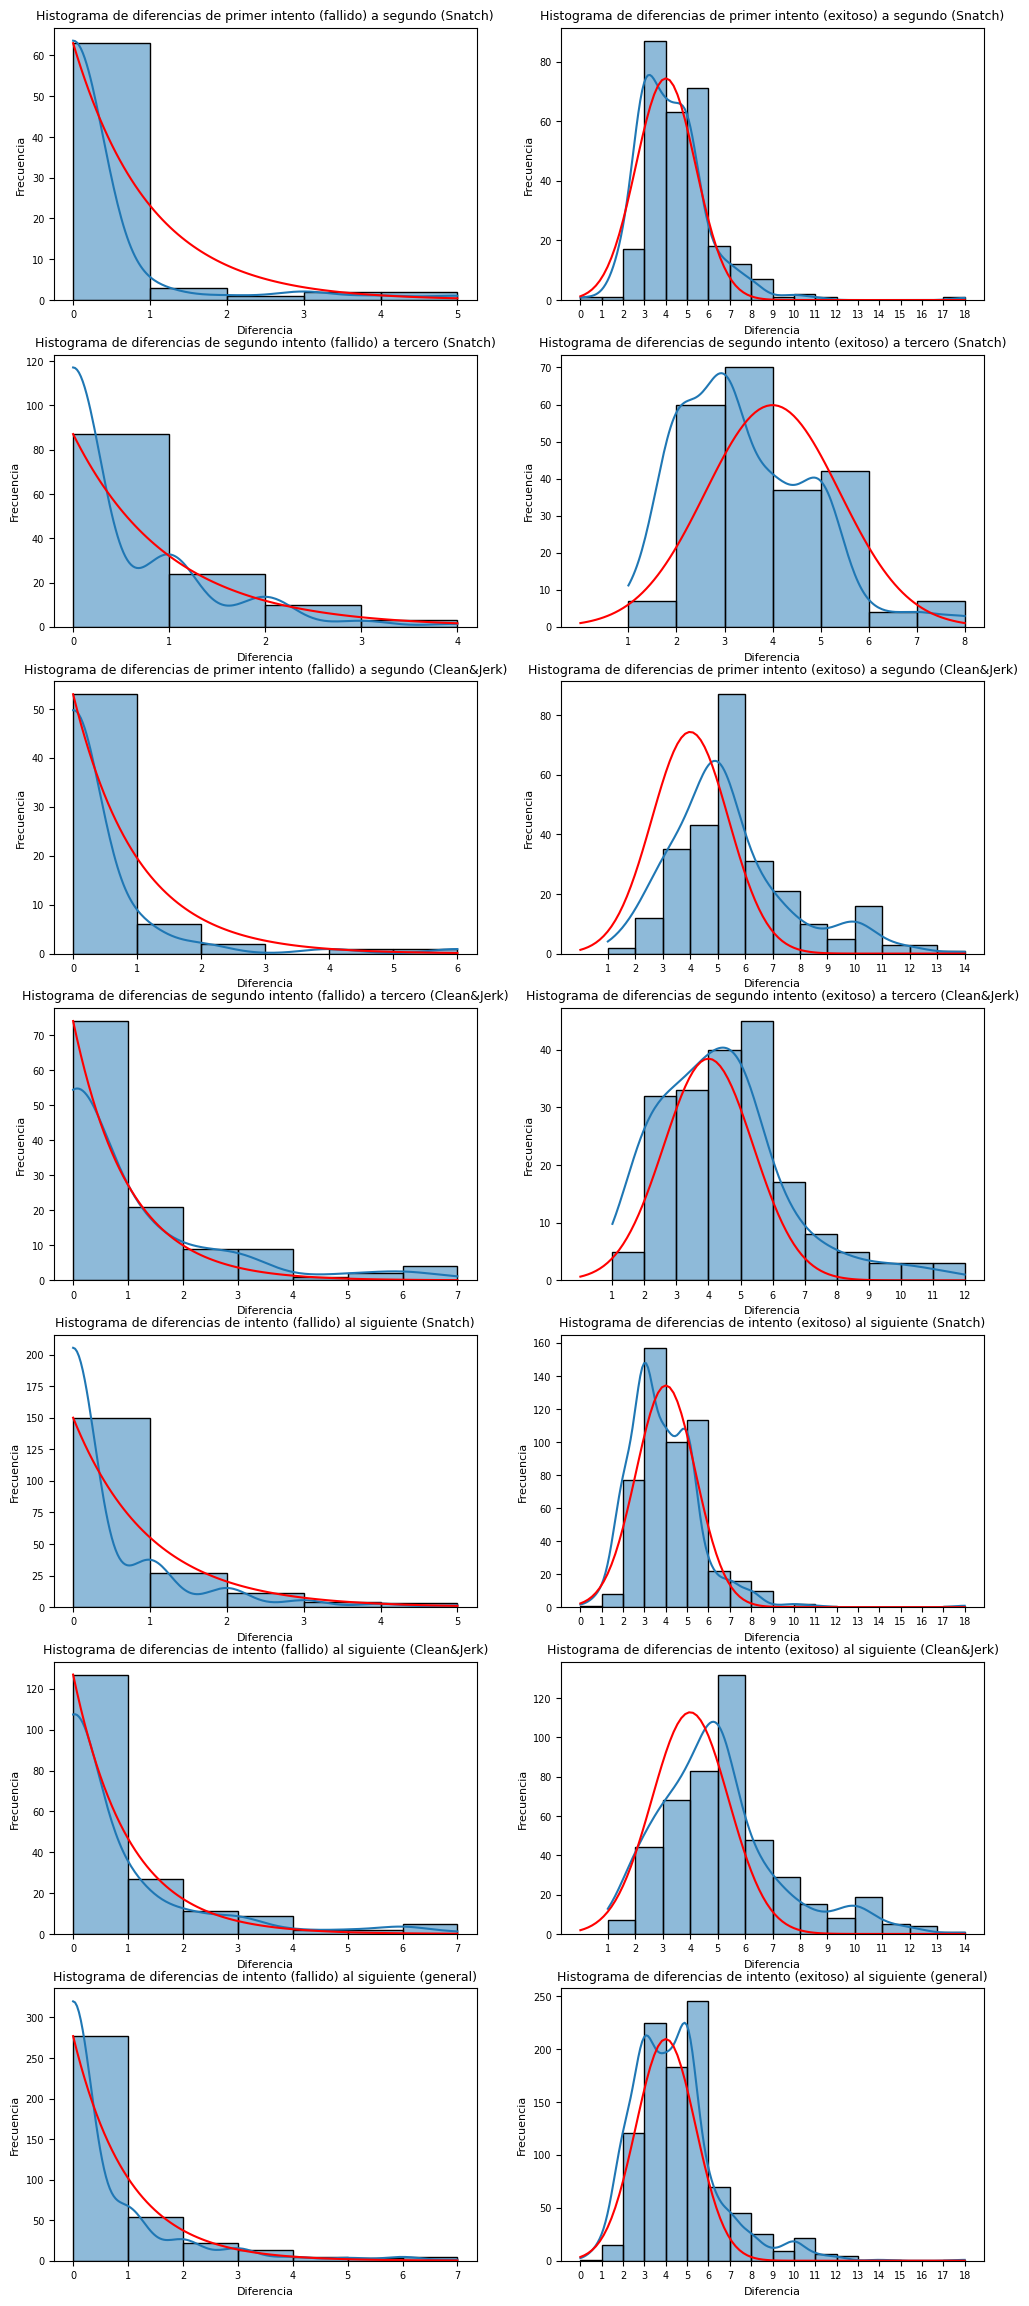

In [125]:
def plot_multiple_consecutive_attempts_differences_histograms():
    """ Crea varios histogramas de las diferencias entre intentos consecutivos

    Args:
        None
    Returns:
        None
    """

    # Gráficas a plotear
    to_plot = [(fail_first_to_second_snatch, "primer intento (fallido) a segundo (Snatch)"),
    (success_first_to_second_snatch, "primer intento (exitoso) a segundo (Snatch)"),
    (fail_second_to_third_snatch, "segundo intento (fallido) a tercero (Snatch)"),
    (success_second_to_third_snatch, "segundo intento (exitoso) a tercero (Snatch)"),
    (fail_first_to_second_clean_and_jerk, "primer intento (fallido) a segundo (Clean&Jerk)"),
    (success_first_to_second_clean_and_jerk, "primer intento (exitoso) a segundo (Clean&Jerk)"),
    (fail_second_to_third_clean_and_jerk, "segundo intento (fallido) a tercero (Clean&Jerk)"),
    (success_second_to_third_clean_and_jerk, "segundo intento (exitoso) a tercero (Clean&Jerk)"),

    (fail_first_to_second_snatch + fail_second_to_third_snatch, "intento (fallido) al siguiente (Snatch)"),
    (success_first_to_second_snatch + success_second_to_third_snatch, "intento (exitoso) al siguiente (Snatch)"),
    (fail_first_to_second_clean_and_jerk + fail_second_to_third_clean_and_jerk, "intento (fallido) al siguiente (Clean&Jerk)"),
    (success_first_to_second_clean_and_jerk + success_second_to_third_clean_and_jerk, "intento (exitoso) al siguiente (Clean&Jerk)"),

    (fail_first_to_second_snatch + fail_second_to_third_snatch + fail_first_to_second_clean_and_jerk + fail_second_to_third_clean_and_jerk, "intento (fallido) al siguiente (general)"),
    (success_first_to_second_snatch + success_second_to_third_snatch + success_first_to_second_clean_and_jerk + success_second_to_third_clean_and_jerk, "intento (exitoso) al siguiente (general)")]

    # Inicializa los subplots y los iteradores
    fig, axs = plt.subplots(nrows = int(len(to_plot)/2), ncols= 2, figsize=(12,29))
    i = 0
    j = 0

    for plot in to_plot:
        # Toma las diferencias menores que 40
        difs = [x for x in plot[0] if x < 40]

        # Crea el histograma
        sns.histplot(difs, ax=axs[i, j], kde=True, bins=range((int)(min(difs)), (int)(max(difs)) + 1), stat="count")
        axs[i, j].set_xlabel("Diferencia", fontsize = 8)
        axs[i, j].set_ylabel("Frecuencia", fontsize = 8)
        axs[i, j].set_title("Histograma de diferencias de " + plot[1], fontsize = 9)
        axs[i, j].set_xticks(range((int)(min(difs)), (int)(max(difs)) + 1))  # Asegura que los ticks estén en números enteros

        counts = [difs.count(x) for x in difs]
        x_vals = np.linspace(0, max(difs), 100)
        if j == 0:
            y_vals = max(counts)/np.exp(x_vals)
        else:
            median = 4
            deviation = 1.4
            y_vals = 3 * max(counts) / (deviation * np.sqrt(2 * np.pi)) * np.exp(-(x_vals - median) ** 2 / (2 * deviation ** 2))

        # Añade la gráfica de la sigmoide
        axs[i, j].plot(x_vals, y_vals, color = 'red')
        
        # Modifica los tamaños de fuente
        for tick in axs[i, j].xaxis.get_major_ticks():
            tick.label1.set_fontsize(7)
        for tick in axs[i, j].yaxis.get_major_ticks():
            tick.label1.set_fontsize(7)

        # Actualiza los iteradores
        if j == 0:
            j += 1
        else:
            i += 1
            j = 0

    # Plotea los gráficos
    plt.show()

# Llama a la función
plot_multiple_consecutive_attempts_differences_histograms()

Se observa que, por lo general, se cumplen las siguientes hipótesis:
- Después de un intento fallido, los atletas se vuelven más cautelosos y en el siguiente intento piden entre 0 y 5 Kg de más, con probabilidad decreciente exponencialmente.
- Después de un intento exitoso, los atletas piden entre 1 y 10 Kg de más, con probabilidad que distribuye aproximadamente normal asimétrica (Skewed Gaussian) con media alrededor de 4.
- Del primer al segundo intento hay más variabilidad de diferencia de peso que del segundo al tercero.

## Predicciones

### Simulación de un torneo de levantamiento de pesas

Se aplicará toda la información recopilada en las secciones anteriores para simular torneos de levantamiento de pesas. Se sigue fielmente el orden de ejecución de la competencia descrita anteriormente, y se toman en cuenta las hipótesis comprobadas para determinar las variables aleatorias (peso del primer intento, probabilidad de éxito de un intento, diferencia de peso entre intentos consecutivos).

In [142]:
def simulate_weightlifting(athletes_df):
    """Simula un torneo de levantamiento de pesas para una determinada categoría de peso.

    Args:
      athletes_df: Un dataframe de pandas con los atletas clasificados que tiene las siguientes columnas: name, gender, average_snatch, average_clean_and_jerk.

    Returns:
      Un dataframe de pandas con los resultados del torneo.
    """

    # Filtra los atletas calificados
    qualified_athletes = athletes_df

    # Inicializa el diccionario de resultados del atleta
    athlete_results = {athlete: [] for athlete in qualified_athletes['name']}

    # Simula el arranque y el envión de forma independiente
    for i in range(2):
      # Inicializa el diccionario de mejor intento
      best_attempt = {athlete: 0 for athlete in qualified_athletes['name']}

      # Inicializa el montón de intentos actuales (Heap de mínimos)
      current_attempts = []

      # Función para simular un intento
      def simulate_attempt(weight_to_lift, name, avg, attempt_number):
          heappush(current_attempts, (weight_to_lift, name, avg, attempt_number))

      # Simula los primeros intentos
      for _, row in qualified_athletes.iterrows():
          avg = row['average_snatch']
          if i == 1:
            avg = row['average_clean_and_jerk']
          weight_to_lift = (int)(np.random.normal(avg - 4, (avg - 4) * 0.05))  # 5% desviación estándar
          simulate_attempt(weight_to_lift, row['name'], avg, 1)

      # Simula los levantamientos
      while current_attempts:
          # Obtiene el intento con el menor peso a levantar
          weight_to_lift, name, avg, attempt_number = heappop(current_attempts)

          # Determina si el atleta tiene éxito en el intento
          is_successful = np.random.rand() < success_probability(weight_to_lift, avg)

          # Actualiza el mejor intento si tiene éxito
          if is_successful:
              best_attempt[name] = max(best_attempt[name], weight_to_lift)

          # Si no es el último intento, inserta un nuevo intento con mayor peso
          if attempt_number < 3:
              if is_successful:
                # Generate delta from an exponential distribution with lambda=1.
                delta = int(np.random.exponential(scale=1))
              else:
                # Generate delta from a normal distribution with mean=4 and standard deviation=1.4.
                delta = int(np.random.normal(loc=4, scale=1.4))
                if delta <= 0:
                   delta = 1
                   
              simulate_attempt(weight_to_lift + delta, name, avg, attempt_number + 1)

      for x in best_attempt:
        athlete_results[x].append(best_attempt[x])

    # Crea una lista de tuplas con el nombre del atleta y el resultado combinado
    ranked_athletes = []
    for athlete, results in athlete_results.items():
        combined_result = sum(results) if all(results) else 0
        ranked_athletes.append((athlete, combined_result))

    # Ordena la lista de tuplas en orden decreciente del resultado combinado
    ranked_athletes.sort(key=lambda x: x[1], reverse=True)

    return ranked_athletes

In [145]:
for i in range(len(weight_classes)):
  # Imprime el encabezado de la categoría de peso
  print('Resultados de la categoría de peso '+str(weight_classes[i])+": ")
  # Simula el levantamiento de pesas para la categoría de peso actual
  results = simulate_weightlifting(weight_classes_dfs[i])
  # Crea una tabla con las columnas atleta y peso total
  table = tabulate.tabulate(results, headers=['Atleta', 'Peso total'])
  # Imprime la tabla
  print(table)
  # Imprime una línea en blanco para separar los resultados de cada categoría de peso
  print()

Resultados de la categoría de peso 49: 
Atleta                   Peso total
---------------------  ------------
Hou Zhihui                      208
Katherin Echandia               190
Mihaela Cambei                  187
Jourdan Delacruz                182
Saikhom Mirabai Chanu           181
Beatriz PirÃ³n                  175
Rosina Randafiarison            168
Surodchana Khambao                0
Nina Sterckx                      0
Fang Wan-ling                     0

Resultados de la categoría de peso 59: 
Atleta                Peso total
------------------  ------------
Luo Shifang                  235
Kuo Hsing-chun               228
Anyelin Venegas              228
Maude Charron                224
Kamila Konotop               219
Dora TchakountÃ©             219
Elreen Ando                  218
Janeth GÃ³mez                208
Lucrezia Magistris           207

Resultados de la categoría de peso 71: 
Atleta                Peso total
------------------  ------------
Angie Palacios   

¿Cómo determinar el ranking final más probable a partir de estas simulaciones? Para capturar con mayor veracidad el resultado esperado, consideramos que alguna forma de combinar los rankings de muchas simulaciones distintas capturaría de forma más veraz el resultado a predecir. Por ello, se realizaron 1000 simulaciones, cada una retornando un ranking determinado. Para cada atleta de la categoría, se suman los lugares que obtuvo en cada ranking. Luego, se termina el ranking como el orden de los atletas de menor a mayor suma, ya que de esta forma los atletas que generalmente obtienen los primeros lugares obtendrán menor suma y por tanto mejor lugar en conjunto, y análogamente peor para los que obtienen resultados más pobres.

In [146]:
def combine_multiple_simulations(num_simulations):
  """Hace múltiples simulaciones de todas las categorías del torneo de Halterofilia, y luego combina los rankings para determinar un ranking final

    Args:
      num_simulations: la cantidad de simulaciones a realizar

    Returns:
      Una lista con los rankings de todas las categorías de peso
  """

  rankings = []

  for i in range(len(weight_classes)):
    # Inicializa el diccionario para almacenar la suma de posiciones de cada atleta
    athlete_sum = {}
    for athlete in weight_classes_dfs[i]['name']:
      # Inicializa el valor de cada atleta en 0
      athlete_sum[athlete] = 0

    # Realiza las simulaciones
    for j in range(num_simulations):
      # Simula el levantamiento de pesas para la categoría de peso actual
      results = simulate_weightlifting(weight_classes_dfs[i])

      # Actualiza la suma de posiciones para cada atleta
      for k in range(len(results)):
        athlete_sum[results[k][0]] += k + 1

    # Ordena el diccionario por valor (suma de posiciones)
    athlete_sum = dict(sorted(athlete_sum.items(), key=lambda item: item[1]))

    # Crea la lista de atletas ordenados según su suma de posiciones
    ranking = []
    for athlete in athlete_sum:
      # Agrega los atletas a la lista de ranking
      ranking += [athlete]

    rankings.append(ranking)

    # Determina el género de la categoría de peso
    gender = 'Hombres'
    if i < 5:
      gender = 'Mujeres'

    table = []

    for j in range(len(ranking)):
      # Añade la posición, el nombre del atleta y su suma de posiciones
      table.append((j+1,ranking[j],athlete_sum[ranking[j]]))

    table = tabulate.tabulate(table, headers=['Pos', 'Atleta', 'Suma'])

    # Imprime los resultados de la categoría de peso
    print('Resultados simulados de la categoría de ' + str(weight_classes[i]) + " Kg (" + gender + "): ")
    print(table)

    # Imprime una línea en blanco para separar los resultados de cada categoría de peso
    print()
  
  return rankings

load_data('classified.json')
paris_2024_rankings = combine_multiple_simulations(1000)

Resultados simulados de la categoría de 49 Kg (Mujeres): 
  Pos  Atleta                   Suma
-----  ---------------------  ------
    1  Nina Sterckx             2515
    2  Hou Zhihui               2588
    3  Mihaela Cambei           4261
    4  Jourdan Delacruz         4621
    5  Surodchana Khambao       4913
    6  Saikhom Mirabai Chanu    6001
    7  Katherin Echandia        6223
    8  Fang Wan-ling            6750
    9  Beatriz PirÃ³n           8185
   10  Rosina Randafiarison     8943

Resultados simulados de la categoría de 59 Kg (Mujeres): 
  Pos  Atleta                Suma
-----  ------------------  ------
    1  Luo Shifang           2439
    2  Maude Charron         3375
    3  Kuo Hsing-chun        3979
    4  Kamila Konotop        4354
    5  Elreen Ando           5455
    6  Anyelin Venegas       5561
    7  Dora TchakountÃ©      6115
    8  Janeth GÃ³mez         6533
    9  Lucrezia Magistris    7189

Resultados simulados de la categoría de 71 Kg (Mujeres): 
  Pos 

## Comparaciones y mediciones entre modelos

Para determinar la precisión de un modelo precisamos de una métrica para compararlos. Una idea es comparar de alguna forma el ranking que devuelve un modelo con respecto al ranking real de la competencia, de forma tal que mientras más **parecidos** sean los rankings, mejor es el modelo. Una medida posible para comparar dos rankings es la distancia de Spearman. La distancia de Spearman es una medida que cuantifica la similitud entre dos conjuntos de clasificaciones ordinales. Cuanto menor sea la distancia de Spearman, más similares serán las clasificaciones.

Cálculo de la distancia de Spearman:
1. Se calculan las diferencias de rango entre los dos rankings para cada elemento.
2. Se elevan al cuadrado cada diferencia de rango.
3. Se suman los cuadrados de las diferencias de rango.
4. Se calcula la raíz cuadrada de la suma de los cuadrados.

In [147]:
def spearman_distance(ordered_ranking, disordered_ranking):
  """Calcula la distancia de Spearman entre dos permutaciones.

  Args:
    ordered_ranking: Una lista que representa el ranking ordenado.
    disordered_ranking: Una lista que representa el ranking desordenado.

  Returns:
    La distancia de Spearman entre los dos rankings.
  """

  # Comprueba que los rankings tengan la misma longitud
  if len(ordered_ranking) != len(disordered_ranking):
    raise ValueError("Las clasificaciones deben tener la misma longitud")

  # Crea un diccionario para almacenar las posiciones de los elementos en la clasificación ordenada
  ordered_positions = {elemento: posicion for posicion, elemento in enumerate(ordered_ranking)}

  # Calcula las diferencias de rango para cada elemento
  rank_differences = []
  for element in disordered_ranking:
    disordered_position = disordered_ranking.index(element)
    ordered_position = ordered_positions[element]
    rank_difference = abs(disordered_position - ordered_position)
    rank_differences.append(rank_difference)

  # Eleva al cuadrado las diferencias de rango
  squared_differences = [dif ** 2 for dif in rank_differences]

  # Calcula la suma de las diferencias de rango al cuadrado
  sum_of_squares = sum(squared_differences)

  # Calcula la raiz cuadrada de la suma de los cuadrados
  spearman_distance = sum_of_squares ** 0.5

  return spearman_distance

Compararemos los resultados de la simulación de la 2024 IWF World Cup con los resultados reales de dicha competencia:

In [151]:
# Simula la competencia pasada
load_data('2024 IWF World Cup.json')
world_cup_simulated_rankings = combine_multiple_simulations(1000)

Resultados simulados de la categoría de 49 Kg (Mujeres): 
  Pos  Atleta                   Suma
-----  ---------------------  ------
    1  Nina Sterckx             2623
    2  Hou Zhihui               2843
    3  Saikhom Mirabai Chanu    3813
    4  Jourdan Delacruz         4683
    5  Surodchana Khambao       4875
    6  Mihaela Cambei           4898
    7  Katherin Echandia        6862
    8  Fang Wan-ling            7396
    9  Beatriz PirÃ³n           7911
   10  Rosina Randafiarison     9096

Resultados simulados de la categoría de 59 Kg (Mujeres): 
  Pos  Atleta                Suma
-----  ------------------  ------
    1  Luo Shifang           2479
    2  Kuo Hsing-chun        3455
    3  Maude Charron         3559
    4  Kamila Konotop        4135
    5  Elreen Ando           5737
    6  Anyelin Venegas       5898
    7  Janeth GÃ³mez         5931
    8  Dora TchakountÃ©      6810
    9  Lucrezia Magistris    6996

Resultados simulados de la categoría de 71 Kg (Mujeres): 
  Pos 

In [153]:
def get_real_ranking(data_file):
    """Calcula el ranking real de la competencia target en data_file.json

    Args:
        data_file: nombre del archivo .json donde están los resultados reales

    Returns:
        None
    """

    # Carga el archivo de datos
    with open(data_file) as f:
        data = json.load(f)

    weight_class_index = -1
    # Itera sobre las categorías de peso
    for weight_class, athletes in data.items():
        weight_class_index += 1

        # Inicializa lista de resultados
        results = []
        gender = ''
        # Itera sobre los atletas
        for athlete, athlete_data in athletes.items():
            gender = athlete_data['sex']
            # Obtiene peso total cargado entre ambos formatos y guarda el par (resultado, atleta)
            total_weight = athlete_data['target']['total weight']
            results.append([total_weight, athlete, total_weight])
    
        # Ordena el ranking por peso total cargado
        ranking = sorted(results, key=lambda x: x[0], reverse=True)

        # Crea lista para permutación del ranking
        real_ranking_permutation = [0 for x in ranking]

        # Busca a los atletas en el ranking real
        for i in range(len(ranking)):
            ranking[i][0] = i + 1 
            for j in range(len(ranking)):
                if world_cup_simulated_rankings[weight_class_index][j] == ranking[i][1]:
                    real_ranking_permutation[j] = i
                    break

        # Genera la tabla formateada
        table = tabulate.tabulate(ranking, headers=['Pos', 'Atleta', 'Resultado'])

        # Traduce gender
        if gender == 'men':
            gender = "Hombres"
        else:
            gender = "Mujeres"

        # Imprime los resultados de la categoría de peso
        print('Resultados reales de la categoría de ' + str(weight_class) + " Kg (" + gender + "): ")
        #print(table)
        #print()

        # Imprime el ranking simulado como permutación del ranking real y la distancia de Spearman correspondiente
        print("Permutación de ranking simulado del ranking real [0, 1, 2, ...]:", real_ranking_permutation)
        print("Distancia de Spearman del ranking simulado respecto al ranking real:", spearman_distance(range(len(ranking)), real_ranking_permutation))

        # Imprime una línea en blanco para separar los resultados de cada categoría de peso
        print()
        
get_real_ranking('2024 IWF World Cup.json')

Resultados reales de la categoría de 49 Kg (Mujeres): 
Permutación de ranking simulado del ranking real [0, 1, 2, ...]: [1, 0, 6, 8, 3, 2, 4, 5, 9, 7]
Distancia de Spearman del ranking simulado respecto al ranking real: 8.12403840463596

Resultados reales de la categoría de 59 Kg (Mujeres): 
Permutación de ranking simulado del ranking real [0, 1, 2, ...]: [0, 2, 1, 7, 4, 3, 8, 5, 6]
Distancia de Spearman del ranking simulado respecto al ranking real: 5.830951894845301

Resultados reales de la categoría de 71 Kg (Mujeres): 
Permutación de ranking simulado del ranking real [0, 1, 2, ...]: [0, 3, 8, 10, 5, 4, 2, 1, 11, 7, 6, 9]
Distancia de Spearman del ranking simulado respecto al ranking real: 13.2664991614216

Resultados reales de la categoría de 81 Kg (Mujeres): 
Permutación de ranking simulado del ranking real [0, 1, 2, ...]: [0, 2, 1, 10, 9, 4, 5, 3, 6, 7, 8]
Distancia de Spearman del ranking simulado respecto al ranking real: 10.295630140987

Resultados reales de la categoría de 81